In [2]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns

from matplotlib.ticker import StrMethodFormatter
from pathlib import Path

ROOT = Path.cwd().parents[0] # Exécution depuis le dossier notebook/
sys.path.append(str(ROOT))

df = pd.read_csv("../output/df_modele_musees.csv")

# Statistiques descriptives


In [3]:
#Aperçu du dataframe : une ligne = un musée pour une année
#df.info()

#Stat desc sur le total de fréquentation
df["total"].describe()

count    1.162500e+04
mean     5.117085e+04
std      3.430392e+05
min      0.000000e+00
25%      2.109000e+03
50%      8.825000e+03
75%      2.816500e+04
max      1.010596e+07
Name: total, dtype: float64

Ce résumé nous donne une première idée des caractéristiques de notre dataset, afin de faire des graphiques plus pertinents par la suite. Par exemple, le fait que l'écart-type soit très grand signifie qu'il y a une forte hétérogénéité entre les musées. Cela se voit de plus car la médiane est de 8 481 visiteurs et la moyenne de 50 186 visiteurs : quelques musées connus concentrent la majorité des visites.

### Représentation géographique

#### Analyse régionale

In [4]:
#DF GEO 
# On enlève les lignes sans coordonnées
df_geo = df.dropna(subset=["latitude", "longitude"]).copy()

# Création de la colonne geometry à partir de lon/lat
gdf_points = gpd.GeoDataFrame(
    df_geo,
    geometry=gpd.points_from_xy(df_geo["longitude"], df_geo["latitude"]),
    crs="EPSG:4326"  # WGS84, le classique lat/lon
)

gdf_points.head()


id_patrimostat id_museofile dateappellation ferme anneefermeture  \
0        0105301        M0963      01/02/2003   NON            NaN   
1        0105301        M0963      01/02/2003   NON            NaN   
2        0105301        M0963      01/02/2003   NON            NaN   
3        0105301        M0963      01/02/2003   NON            NaN   
4        0105301        M0963      01/02/2003   NON            NaN   

             ville codeInseeCommune  annee   payant  gratuit  ...  is_océanie  \
0  BOURG EN BRESSE            01053   2014  53088.0  41560.0  ...           0   
1  BOURG EN BRESSE            01053   2015  76918.0  35942.0  ...           0   
2  BOURG EN BRESSE            01053   2016  74138.0  24813.0  ...           0   
3  BOURG EN BRESSE            01053   2017  73396.0  23736.0  ...           0   
4  BOURG EN BRESSE            01053   2018  62284.0  35932.0  ...           0   

   is_amérique  is_arts_de_l'islam  is_sciences_fondamentales  \
0            0                   0                          0   
1            0                   0                          0   
2            0                   0                          0   
3            0                   0                          0   
4            0                   0                          0   

   is_mémoire_de_l'esclavage  is_littérature  is_militaria  is_egyptien  \
0                          0               0             0            0   
1                          0               0             0            0   
2                          0               0             0            0   
3                          0               0             0            0   
4                          0               0             0            0   

   est_idf                  geometry  
0        0  POINT (5.23652 46.19655)  
1        0  POINT (5.23652 46.19655)  
2        0  POINT (5.23652 46.19655)  
3        0  POINT (5.23652 46.19655)  
4        0  POINT (5.23652 46.19655)  

[5 rows x 56 columns]

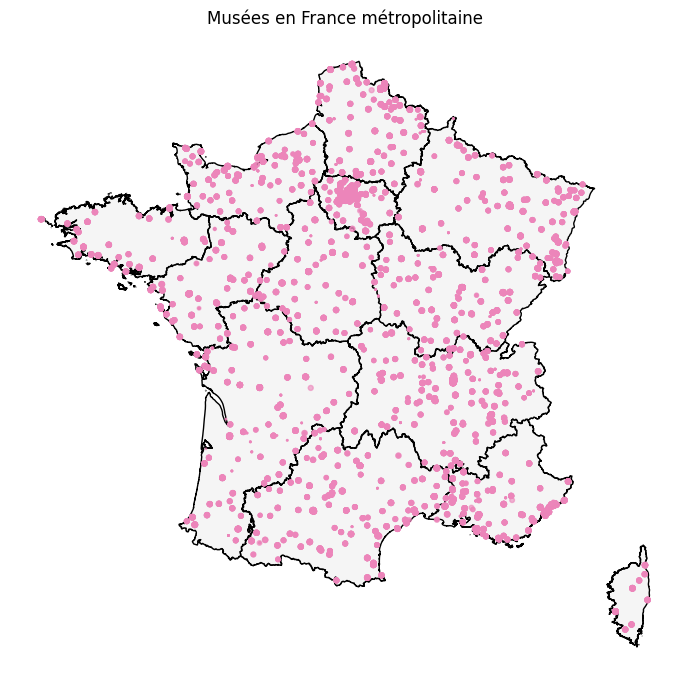

In [ ]:
from cartiflette import carti_download
#carte des musées en FR métro
#Filtre France métropolitaine sur les points
mask_metropole = (
    gdf_points.geometry.y.between(41, 52) &   # latitude
    gdf_points.geometry.x.between(-6, 10)     # longitude
)
gdf_points_metropole = gdf_points[mask_metropole].copy()

#Télécharger la carte des régions
france = carti_download(
    values=["France"],
    crs=4326,
    borders="REGION",
    vectorfile_format="geojson",
    simplification=50,
    filter_by="FRANCE_ENTIERE",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022
)

# garder seulement la métropole
france = france.loc[france["INSEE_REG"] > 10]

#Tracer
fig, ax = plt.subplots(figsize=(7, 9))

# fond de carte
france.plot(ax=ax, color="whitesmoke", edgecolor="black")

# taille des points bornée (évite la grosse tache)
# On utilise la racine carrée (sqrt) ou le log pour mieux étaler l'échelle visuelle
# +1 pour éviter log(0)
ms = np.log1p(gdf_points_metropole["total"]) 

# On normalise pour que la taille soit entre 1 et 20
ms = (ms - ms.min()) / (ms.max() - ms.min()) * 20 + 1

gdf_points_metropole.plot(
    ax=ax,
    markersize=ms,
    color="#ec85ba",
    alpha=0.6
)

ax.set_title("Musées en France métropolitaine")
ax.set_axis_off()
plt.tight_layout()
plt.show()


In [7]:
#CARTE FREQ MOY
import mapclassify


#Fréquentation moyenne par musée dans chaque région
df_region = (
    df.groupby("region")
      .agg(
          visites_totales=("total", "sum"),
          nb_musees=("id_museofile", "nunique")
      )
)

df_region["freq_par_musee"] = df_region["visites_totales"] / df_region["nb_musees"]
df_region = df_region.reset_index()

#Fonction de normalisation des noms de régions
def normalize_name(s):
    """Met les noms de région en minuscule, enlève les espaces et harmonise les tirets."""
    if pd.isna(s):
        return np.nan
    s = str(s).lower()
    s = s.replace("–", "-").replace("—", "-")  # différents tirets → '-'
    s = s.replace("  ", " ")
    return s.strip()

#réer region_clean côté données et côté carte
df_region["region_clean"] = df_region["region"].apply(normalize_name)
france["region_clean"] = france["LIBELLE_REGION"].apply(normalize_name)

#Corrections manuelles sur quelques régions
mapping = {
    "pays-de-la-loire": "pays de la loire",
    "provence-alpes-côte-d'azur": "provence-alpes-côte d'azur",
    "territoires et départements d'outre-mer": np.nan,  # on ignore, pas dans la carte
}

df_region["region_clean"] = df_region["region_clean"].replace(mapping)

#On enlève les lignes sans région métropolitaine
df_region = df_region.dropna(subset=["region_clean"])

#Jointure
france_reg = france.merge(
    df_region[["region_clean", "freq_par_musee"]],
    on="region_clean",
    how="left"
)

#On garde uniquement les régions avec données (métropole)
france_reg_clean = france_reg[france_reg["freq_par_musee"].notna()].copy()

#Classification en quantiles
scheme = mapclassify.Quantiles(france_reg_clean["freq_par_musee"], k=5)

#Tracé de la choroplèthe
fig, ax = plt.subplots(figsize=(10, 10))

france_reg_clean.plot(
    column="freq_par_musee",
    cmap="PuRd",
    legend=True,
    edgecolor="grey",
    linewidth=0.6,
    scheme="Quantiles",   
    k=5,                  
    ax=ax
)

#Légende qualitative
labels = ["Très faible", "Faible", "Moyenne", "Élevée", "Très élevée"]

leg = ax.get_legend()
leg.set_title("Niveau de fréquentation\n(moyenne par musée)")

for lbl, txt in zip(labels, leg.texts):
    txt.set_text(lbl)

ax.set_title("Fréquentation moyenne par musée et par région (quantiles)", 
             fontsize=14, pad=15)
ax.set_axis_off()

plt.tight_layout()
plt.show()


ModuleNotFoundError: No module named 'mapclassify'

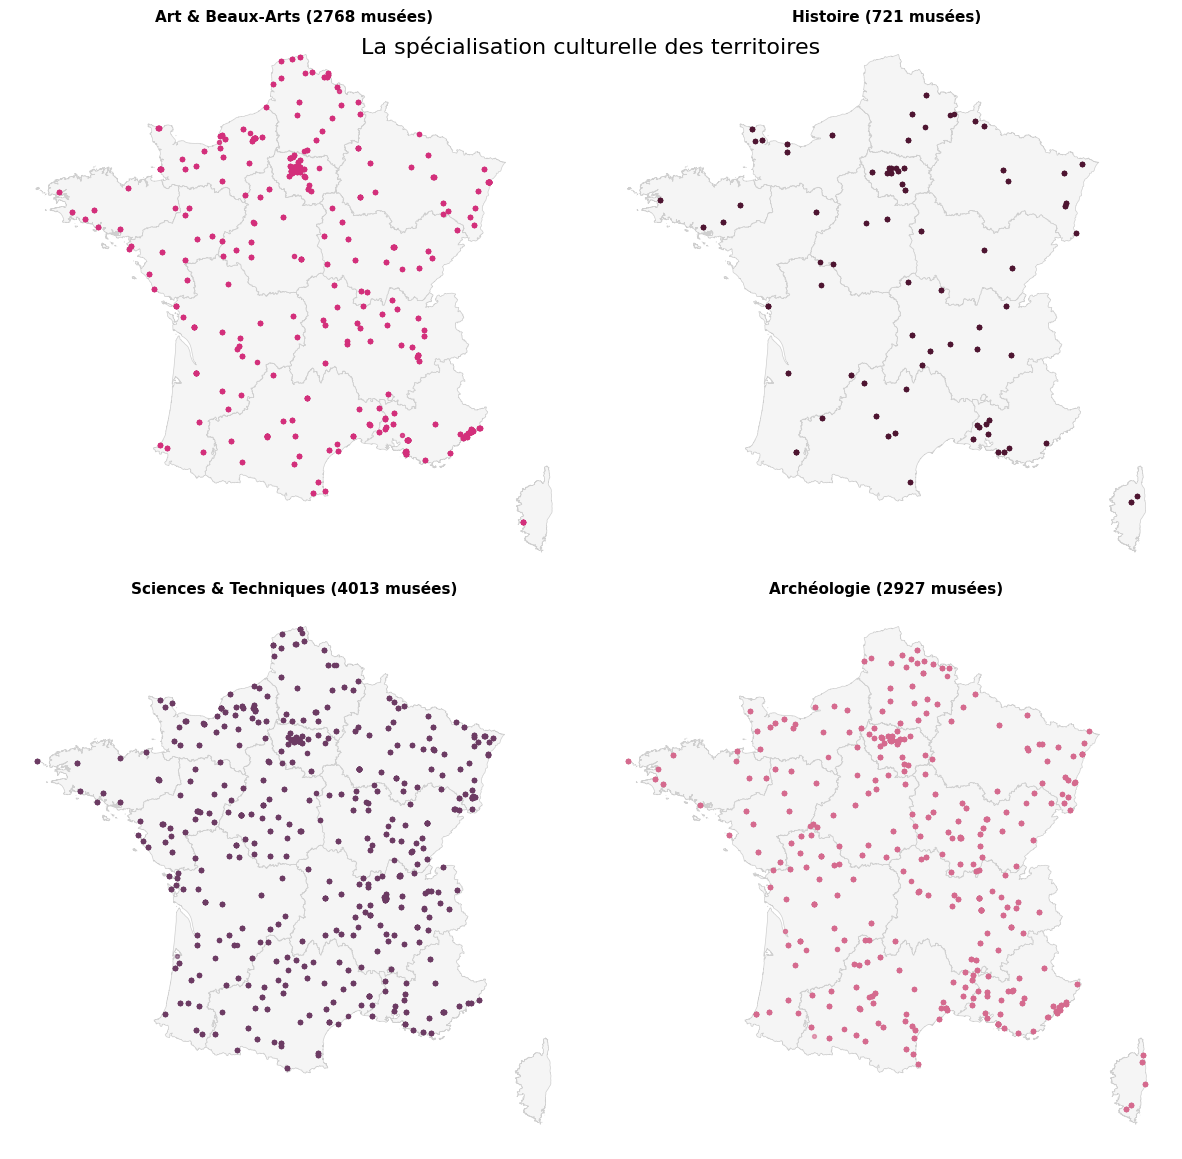

In [ ]:
import matplotlib.pyplot as plt

# 1. On définit une petite fonction pour trier TES données existantes
# On regarde ce qu'il y a dans la colonne "domaine_thematique" (ou "themes")
def classer_musee(valeur_brute):
    s = str(valeur_brute).lower()
    if "techn" in s or "indust" in s or "scienc" in s:
        return "Sciences & Techniques"
    elif "archéo" in s or "préhist" in s:
        return "Archéologie"
    elif "art" in s or "peinture" in s or "beaux" in s:
        return "Art & Beaux-Arts"
    elif "hist" in s or "guerre" in s:
        return "Histoire"
    return "Autre"

# 2. On applique ce tri sur TON dataframe (gdf_points_metropole)
# Assure-toi que la colonne s'appelle bien 'domaine_thematique' (standard Muséofile)
# Sinon remplace par le nom de ta colonne
col_source = "domaine_thematique" if "domaine_thematique" in gdf_points_metropole.columns else "themes"
gdf_points_metropole["categorie_carte"] = gdf_points_metropole[col_source].apply(classer_musee)

# -----------------------------------------------------------
# 3. GÉNÉRATION DES 4 CARTES (Small Multiples)
# -----------------------------------------------------------

themes_vises = ["Art & Beaux-Arts", "Histoire", "Sciences & Techniques", "Archéologie"]
couleurs = ["#D32F7B", "#4E1531", "#6C3B63", "#D56A8E"] # Rouge, Bleu, Vert, Violet

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
axes = axes.flatten() # Pour pouvoir faire axes[0], axes[1]...

for i, theme in enumerate(themes_vises):
    ax = axes[i]
    
    # A. Fond de carte (Ta variable 'france' issue de Cartiflette)
    france.plot(ax=ax, color="#f5f5f5", edgecolor="#cfcfcf", linewidth=0.5)
    
    # B. On filtre TES points pour ne garder que ceux du thème en cours
    subset = gdf_points_metropole[gdf_points_metropole["categorie_carte"] == theme]
    
    # C. On trace les points
    if not subset.empty:
        subset.plot(
            ax=ax,
            markersize=8,          # Points pas trop gros
            color=couleurs[i],     # Une couleur par thème
            alpha=0.6,             # Un peu transparent
            label=theme
        )
        titre = f"{theme} ({len(subset)} musées)"
    else:
        titre = f"{theme} (Pas de données)"

    ax.set_title(titre, fontsize=11, fontweight='bold')
    ax.set_axis_off()

fig.suptitle("La spécialisation culturelle des territoires", fontsize=16, y=0.94)
plt.tight_layout()
plt.show()

## Accessibilité tarifaire 

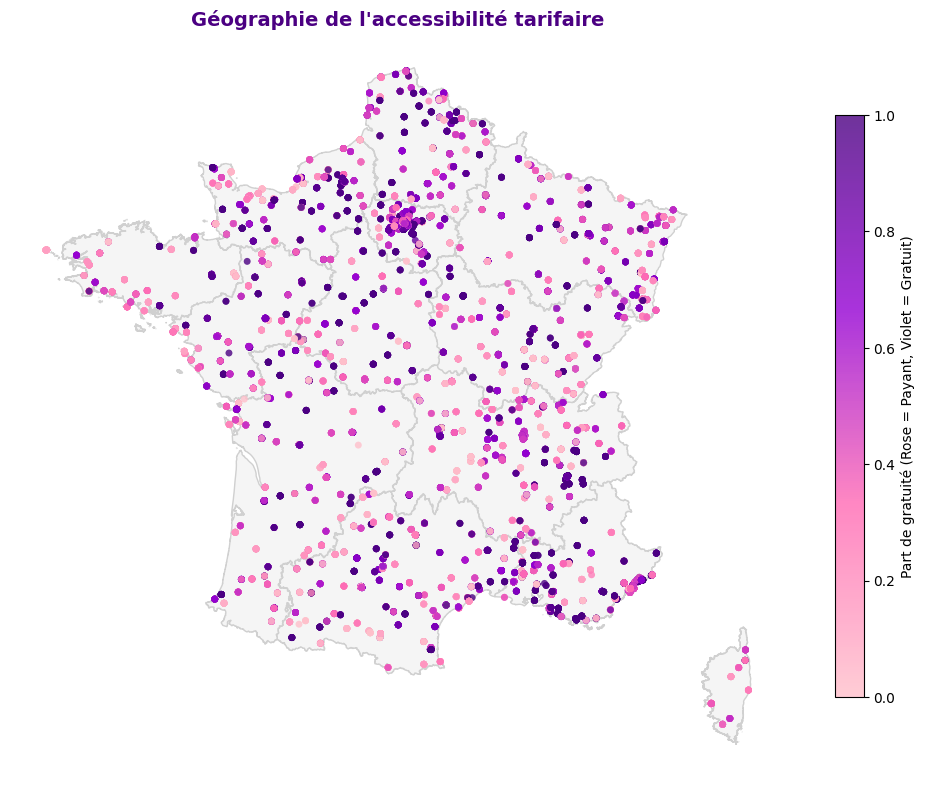

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

# 1. Création de la palette personnaliséequi correspond à la charte graphique 
# On définit une liste de couleurs : du Rose (#FF69B4) vers le Violet foncé (#4B0082)
colors = ["#FFC0CB", "#FF69B4", "#9400D3", "#4B0082"] # Rose pâle -> Hot Pink -> Violet -> Indigo
cmap_rose_violet = LinearSegmentedColormap.from_list("my_rose_violet", colors)

# 2. Calcul du ratio 
gdf_points_metropole["ratio_gratuit"] = gdf_points_metropole["gratuit"] / gdf_points_metropole["total"]

# 3. Tracé
fig, ax = plt.subplots(figsize=(10, 10))

# Fond de carte neutre
france.plot(ax=ax, color="#f5f5f5", edgecolor="#d0d0d0")

# Les points avec ta nouvelle palette
sc = ax.scatter(
    gdf_points_metropole.geometry.x,
    gdf_points_metropole.geometry.y,
    c=gdf_points_metropole["ratio_gratuit"],
    cmap=cmap_rose_violet,  
    s=25,
    alpha=0.8,
    edgecolor="none" # Pas de bordure pour que la couleur ressorte mieux
)

# Barre de couleur
cbar = plt.colorbar(sc, ax=ax, shrink=0.6)
cbar.set_label("Part de gratuité (Rose = Payant, Violet = Gratuit)", fontsize=10)

ax.set_title("Géographie de l'accessibilité tarifaire", fontsize=14, fontweight='bold', color="#4B0082")
ax.set_axis_off()
plt.tight_layout()
plt.show()

Cette carte représente la part de gratuité des musées en métropole, mesurée par le ratio entre entrées gratuites et entrées totales. La distribution spatiale ne fait apparaître **aucune fracture géographique nette** à l’échelle nationale : ni gradient Nord–Sud, ni opposition centre–périphérie.

On observe en revanche une **forte hétérogénéité locale**, avec la coexistence de musées majoritairement gratuits et majoritairement payants au sein d’un même territoire. Cette dispersion est particulièrement visible dans les grandes régions urbaines, notamment en Île-de-France.

Ces résultats suggèrent que la politique de gratuité relève avant tout de **choix institutionnels et de modèles économiques**, plutôt que de contraintes géographiques. La carte doit ainsi être interprétée comme une géographie des pratiques tarifaires, et non comme une mesure de l’attractivité ou de la fréquentation des musées.


In [ ]:
import folium
from folium.plugins import MarkerCluster

# 1. Création de la carte
m = folium.Map(location=[46.5, 2.5], zoom_start=6, tiles="CartoDB positron") 
marker_cluster = MarkerCluster().add_to(m)

def get_color(visiteurs):
    if pd.isna(visiteurs): return "gray"
    if visiteurs > 100000: return "darkpurple"
    elif visiteurs > 10000: return "purple"
    else: return "pink"

# 2. Boucle sécurisée
for row in gdf_points_metropole.itertuples():
    
    # --- CORRECTION ICI ---
    # On calcule le % de gratuité AVANT, avec une sécurité
    if pd.notna(row.total) and row.total > 0 and pd.notna(row.gratuit):
        taux_gratuite = round((row.gratuit / row.total) * 100, 1)
        txt_gratuite = f"{taux_gratuite}%"
    else:
        txt_gratuite = "N/A" # Si total est 0 ou vide
        
    # On gère aussi l'affichage du total pour éviter les "nan"
    txt_total = f"{int(row.total):,}" if pd.notna(row.total) else "Inconnu"
    # ----------------------

    html_popup = f"""
    <div style="font-family: sans-serif; width: 200px;">
        <h4 style="color: #4B0082; margin-bottom: 5px;">{row.nom_officiel}</h4>
        <b>Ville :</b> {row.ville}<br>
        <b>Visiteurs :</b> {txt_total}<br>
        <b>Gratuité :</b> {txt_gratuite}
    </div>
    """
    
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        popup=folium.Popup(html_popup, max_width=300),
        tooltip=row.nom_officiel,
        icon=folium.Icon(color=get_color(row.total), icon="info-sign")
    ).add_to(marker_cluster)

# Afficher la carte
m

# Sauvegarde dans le dossier output
output_path = OUTPUT_DIR / "carte_interactive_musees.html"
m.save(str(output_path))
print(f"Carte interactive sauvegardée : {output_path}")

Carte interactive sauvegardée : c:\Users\valen\OneDrive\Documents\GitHub\prediction-musee\notebook\output\carte_interactive_musees.html


In [ ]:
import folium

# -----------------------------------------------------------
# ÉTAPE 0 : DÉDOUBLONNAGE (Gardons l'année la plus récente)
# -----------------------------------------------------------

# 1. On trie par année décroissante (le plus récent en haut)
gdf_sorted = gdf_points_metropole.sort_values("annee", ascending=False)

# 2. On supprime les doublons d'ID, en gardant la première ligne trouvée (donc la plus récente)
gdf_unique = gdf_sorted.drop_duplicates(subset="id_museofile").copy()

# On vérifie la différence
print(f"Lignes avant dédoublonnage : {len(gdf_points_metropole)}")
print(f"Musées uniques (Carte)    : {len(gdf_unique)}")

# -----------------------------------------------------------
# ÉTAPE 1 : PRÉPARATION DE LA CARTE À CALQUES
# -----------------------------------------------------------

m_layers = folium.Map(location=[46.5, 2.5], zoom_start=6, tiles="CartoDB positron")

colors = {
    "Art & Beaux-Arts": "#FF007F",     
    "Histoire": "#4B0082",               
    "Sciences & Techniques": "#9400D3", 
    "Archéologie": "#FF69B4",            
    "Autre": "#D8BFD8"                   
}

# Création des groupes
groups = {}
for theme in colors.keys():
    groups[theme] = folium.FeatureGroup(name=theme)

# -----------------------------------------------------------
# ÉTAPE 2 : BOUCLE SUR LE DATAFRAME UNIQUE
# -----------------------------------------------------------

# IMPORTANT : On boucle sur 'gdf_unique', pas sur le gros dataframe
for row in gdf_unique.itertuples():
    
    # Récupération du thème (via ta colonne créée précédemment)
    # Adapte le nom 'categorie_carte' si besoin
    theme = getattr(row, "categorie_carte", "Autre")
    
    # Sécurité si le thème n'est pas dans notre dictionnaire de couleurs
    if theme not in colors:
        theme = "Autre"

    # Construction du Popup (avec l'année pour info)
    annee_data = int(row.annee) if pd.notna(row.annee) else "?"
    visiteurs = int(row.total) if pd.notna(row.total) else 0
    
    popup_txt = f"""
    <div style="font-family:sans-serif; width:180px">
        <b>{row.nom_officiel}</b><br>
        <i style="color:gray">{row.ville}</i><br>
        <hr style="margin:5px 0">
        <b>Thème :</b> {theme}<br>
        <b>Visiteurs ({annee_data}) :</b> {visiteurs:,}
    </div>
    """
    
    # Ajout du cercle au bon groupe
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=5,
        color=colors[theme],
        fill=True,
        fill_color=colors[theme],
        fill_opacity=0.6,
        popup=folium.Popup(popup_txt, max_width=250),
        tooltip=f"{row.nom_officiel} ({theme})"
    ).add_to(groups[theme])

# Ajout des groupes et du contrôleur à la carte
for group in groups.values():
    group.add_to(m_layers)

folium.LayerControl(collapsed=False).add_to(m_layers)

# Sauvegarde
output_layers = OUTPUT_DIR / "carte_interactive_calques.html"
m_layers.save(str(output_layers))

print(f"Carte générée : {output_layers}")
m_layers

Lignes avant dédoublonnage : 10926
Musées uniques (Carte)    : 1187
Carte générée : c:\Users\valen\OneDrive\Documents\GitHub\prediction-musee\notebook\output\carte_interactive_calques.html


## Analyse globale de la fréquentation

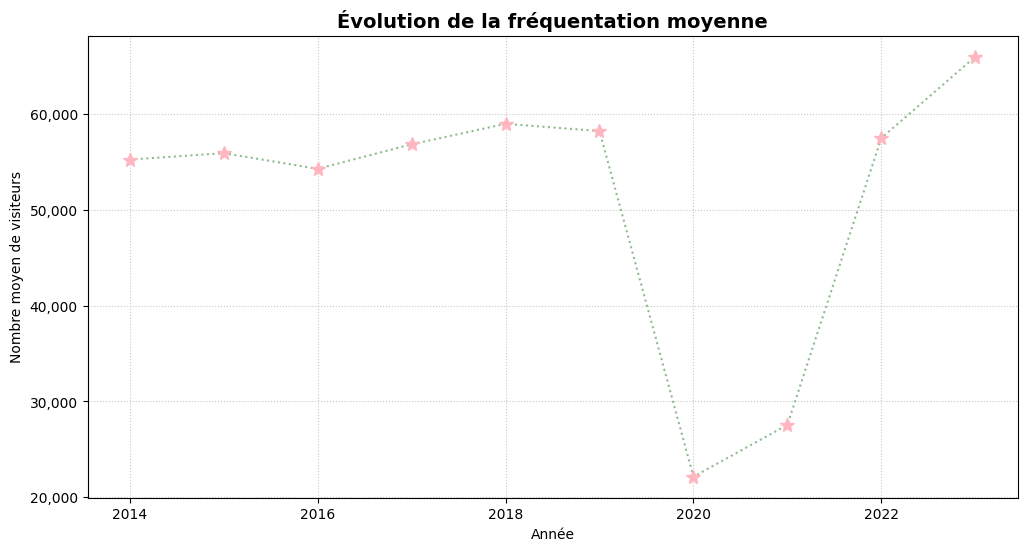

In [5]:
# ÉVOLUTION DE LA FRÉQUENTATION MOYENNE

df_year = df.groupby("annee")["total"].mean().reset_index()

plt.figure(figsize=(12,6))

plt.plot(df_year["annee"], df_year["total"], 
        marker="*", markersize = "10", markeredgecolor="lightpink", markerfacecolor="lightpink", 
        linestyle=':', color ="darkseagreen")

# formater l'axe y pour lisibilité
ax = plt.gca()
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

plt.title("Évolution de la fréquentation moyenne", fontsize=14, fontweight='bold')
plt.xlabel("Année", fontsize=10)
plt.ylabel("Nombre moyen de visiteurs", fontsize=10)

plt.grid(True, linestyle=':', alpha=0.7)

plt.show()

Alors que la fréquentation moyenne pré-COVID stagnait autour de 55 000 de visiteurs par an, la chute due au COVID semble avoir lancé une nouvelle dynamique. On observe d'abord un retour à la normale en 2022, puis une hausse de la fréquentation moyenne en 2023. Dans notre modélisation, nous verrons dans quelle mesure la crise du COVID et le rebond qui l'a suivie impacte la précision de nos prédictions.

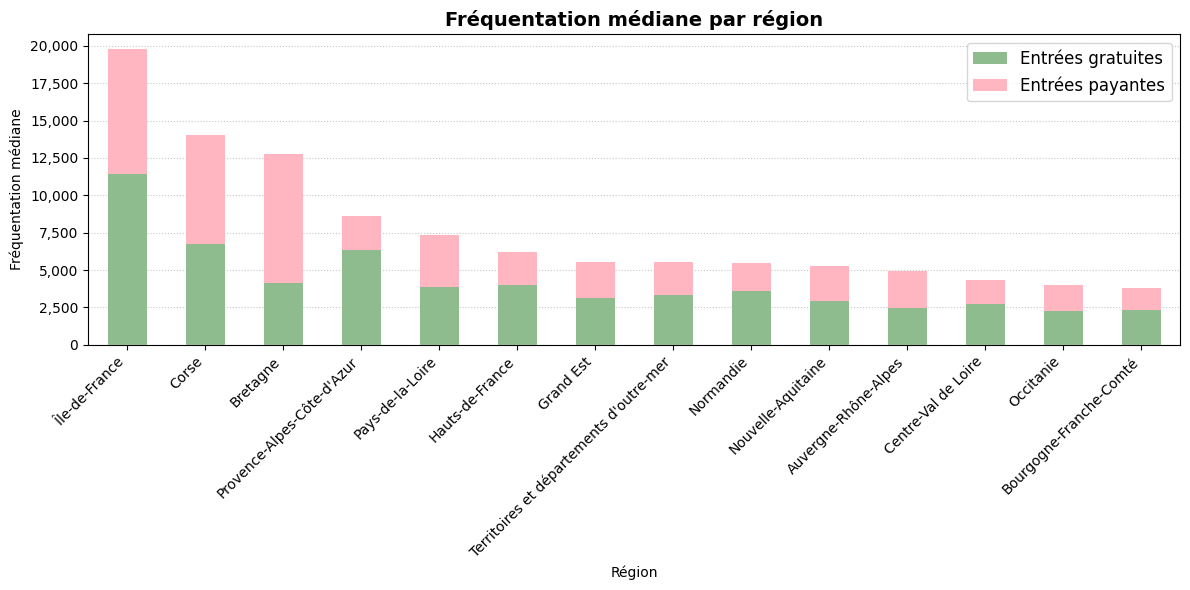

In [6]:
# FRÉQUENTATION MÉDIANE PAR RÉGION : ENTRÉES PAYANTES ET GRATUITES

df_med_sep = (
    df.groupby("region")[["gratuit", "payant"]]
      .median()
      .assign(total_med=lambda x: x["gratuit"] + x["payant"])   # création d'une colonne total pour le tri
      .sort_values("total_med", ascending=False)
)

df_med_sep[["gratuit", "payant"]].plot(  # affichage des colonnes gratuit et médian (pas total)
    kind="bar",
    stacked=True,   # barres empilées
    figsize=(12,6),
    color=["darkseagreen", "lightpink"],
    zorder=3    # mettre la grille en arrière plan
)

ax = plt.gca()
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

plt.title("Fréquentation médiane par région", fontsize=14, fontweight='bold')
plt.xlabel("Région", fontsize=10)
plt.ylabel("Fréquentation médiane", fontsize=10)

plt.xticks(rotation=45, ha="right")
plt.legend(["Entrées gratuites", "Entrées payantes"], fontsize=12)

plt.grid(axis = 'y', linestyle=':', alpha=0.7, zorder=0)    # mettre la grille en arrière plan

plt.tight_layout()
plt.show()

Dans un premier temps, nous avons tenté de regarder la fréquentation moyenne par région. Or, les valeurs atteintes par les musées d'Île-de-France n'étaient pas propices à la comparaison régionale. Nous nous sommes donc intéressées à la médiane qui permet une meilleure interprétation des tendances en limitant l'importance des valeurs aberrantes.

On observe que l'Île-de-France, la Corse et la Bretagne possèdent une fréquentation médiane similaire. Néanmoins, la structure de cette fréquentation diffère : les entrées gratuites représentent 57.9% des entrées totales en Île-de-France, alors que la Bretagne est l'une des régions avec la plus faible proportion d'entrées gratuites avec seulement 39.8%. Dans la majorité des régions, il apparaît que les entrées gratuites représentent plus de la moitié de la fréquentation médiane des musées.

In [14]:
# TOP 10 DES MUSÉES LES PLUS VISITÉS HORS IDF

df_sans_idf = df[df["region"] != "Île-de-France"]

top_musees_fr = (
    df_sans_idf.groupby("nom_officiel")
      .agg(                                       # sélectionner plusieurs colonnes pour le tableau
          total_visites=("total", "sum"),
          region=("region", "first"),                           
          domaine=("domaine_list", "first"),
      rural=("categorie", lambda x: (x == "musée en milieu rural").any()) 
      )
      .sort_values("total_visites", ascending=False)
      .head(10)
      .reset_index()
)

top_musees_fr.columns = [
    "Nom du musée",
    "Total des visites",
    "Région",
    "Domaines thématiques",
    "Rural"
]

top_musees_fr["Domaines thématiques"] = top_musees_fr["Domaines thématiques"].str.slice(0, 50) + "…"    # limiter le nombre de caractères pour lisibilité

styled_top = (
    top_musees_fr.style
    .format({"Total des visites": "{:,.0f}"})    # formater la colonne total
    .map(lambda val: 'color: darkseagreen' if val==True else 'color: lightpink', subset=['Rural'])     # colorer la colonne rural
    .set_table_styles([{'selector': 'th', 'props': [('text-align', 'center')]}])  # centrer les headers
    .set_properties(**{'text-align': 'left'})     # aligner le texte à gauche
    .set_caption('<span style="font-size:14px; font-weight:bold;">Top 10 des musées hors IDF</span>')    # ajouter un titre
)

styled_top

Dans un premier temps, il est important de souligner que seuls les trois premiers musées de ce classement arrivent à concurrencer les musées d'Île-de-France pour se classer dans le top 10 des musées français. On remarque de plus une différence sur les domaines thématiques qui attirent les visiteurs entre l'Île-de-France et le reste des régions. En effet, l'archéologie ne ressort pas beaucoup en Île-de-France, plutôt axée sur l'art, alors qu'elle est prépondérante en région. Enfin, on compte quatre musées situés en zone rurale, ce qui parait étonnant à première vue mais se justifie par l'importance historique des lieux.

In [15]:
# TOP 10 DES MUSÉES AYANT PERDU LE PLUS DE VISITEURS

perte = (
    df.groupby("nom_officiel")
    .agg(
      croissance=("croissance_total", "sum"),
      total_visites=("total","sum"),
      region=("region","first"),
      domaine=("domaine_list","first"),
      rural=("categorie", lambda x: (x == "musée en milieu rural").any())
    )       
    .sort_values("croissance",ascending=True)
    .head(10)
    .reset_index()
)

perte.columns = [
  "Nom du musée",
  "Croissance",
  "Total des visites",
  "Région",
  "Domaines thématiques",
  "Rural"
]

perte["Domaines thématiques"] = perte["Domaines thématiques"].str.slice(0, 50) + "…" 

styled_perte = (
    perte.style
  .format({"Croissance": "{:,.3f}", "Total des visites": "{:,.0f}"})
    .map(lambda val: 'color: darkseagreen' if val==True else 'color: lightpink', subset=['Rural'])
    .set_table_styles([{'selector': 'th', 'props': [('text-align', 'center')]}])
    .set_properties(**{'text-align': 'left'})
    .set_caption('<span style="font-size:14px; font-weight:bold;">Musées avec la plus forte décroissance de fréquentation</span>')
)

styled_perte

La baisse de fréquentation est particulièrement prononcée pour le musée de la Renaissance en Champagne, avec un recul proche de 7%. Les autres musées enregistrent des baisses similaires, malgré leurs profils très différents. En effet, ce classement est constitué d'établissements de toutes tailles, situés dans des régions variées et couvrant des domaines thématiques divers. Nous pouvons alors nous demander si notre modélisation arrivera à rester performante face à ces profils à première vue hétérogènes.

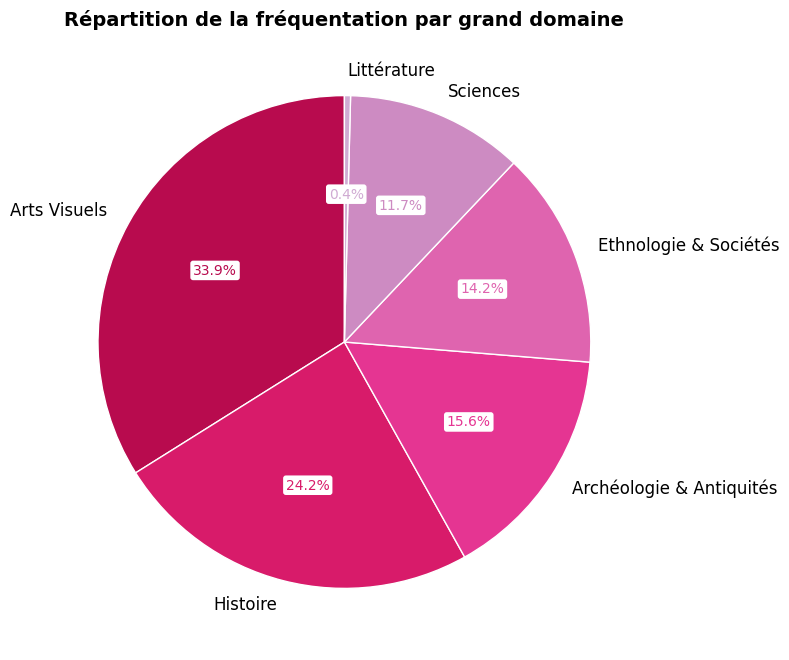

In [9]:
# PROPORTION DE CHAQUE DOMAINE DANS LA FRÉQUENTATION TOTALE

categories = {
    "Histoire": ["is_histoire", "is_mémoire_de_l'esclavage", "is_militaria"],
    "Arts Visuels": ["is_beaux_arts", "is_arts_décoratifs", "is_art_moderne_et_contemporain", "is_photographie", "is_arts_de_l'islam"],
    "Ethnologie & Sociétés": ["is_ethnologie", "is_afrique", "is_asie", "is_océanie", "is_amérique"],
    "Archéologie & Antiquités": ["is_archéologie", "is_egyptien"],
    "Sciences": ["is_technique_et_industrie", "is_sciences_de_la_nature", "is_sciences_fondamentales"],
    "Littérature": ["is_littérature"]
}

# Création d'un dictionnaire pour stocker les valeurs de fréquentation totale
frequentation_categories = {
    cat: (df[cols].max(axis=1) * df['total'].fillna(0)).sum()
    for cat, cols in categories.items()
}

frequentation_categories = pd.Series(frequentation_categories).sort_values(ascending=False)

# Préparation des titres pour le graphique
noms_categories = [col.replace("is_", "").replace("_", " ").title() for col in frequentation_categories.index]

# Palette de couleurs
cmap = plt.get_cmap("PuRd")

# Graphique
fig, ax = plt.subplots(figsize=(8,8))

wedges, texts, autotexts = ax.pie(
    frequentation_categories, 
    labels=noms_categories, 
    autopct='%1.1f%%', 
    startangle=90,              # angle de la première part
    colors = cmap([0.8,0.7,0.6,0.5,0.4,0.3]),
    wedgeprops=dict(edgecolor='white')
)

for text in texts:
    text.set_fontsize(12)

for i, autotext in enumerate(autotexts):
    color_part = wedges[i].get_facecolor()   # récupère la couleur de la part
    autotext.set_fontsize(10)
    autotext.set_color(color_part)           # même couleur que la part
    autotext.set_bbox(dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2'))

plt.title("Répartition de la fréquentation par grand domaine", fontsize=14, fontweight='bold')
plt.show()

Les musées consacrés aux arts visuels représentent un tiers de la fréquentation totale. Ils sont suivis de près par les musées historiques et les musées d’archéologie, qui, ensemble, concentrent également plus d’un tiers des visites. Les musées scientifiques arrivent en avant-dernière position, avec seulement 11.7% de la fréquentation globale.

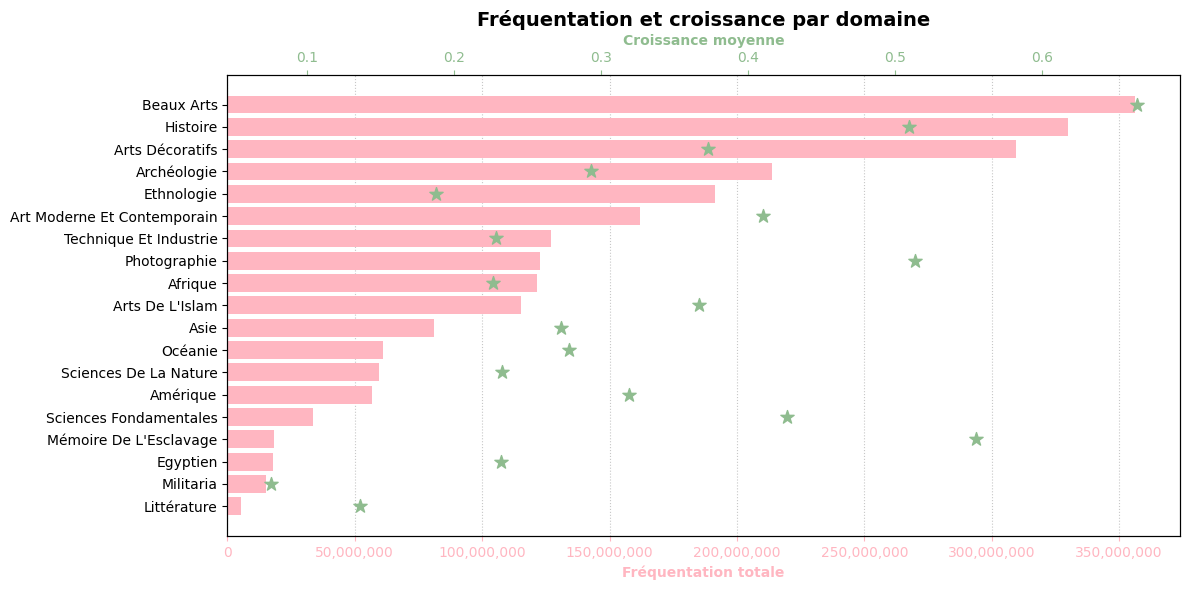

In [10]:
# FRÉQUENTATION ET CROISSANCE MOYENNE DE CHAQUE DOMAINE

domain_cols = df.filter(regex="^is_")

# Fréquentation par domaine
freq = {
    col.replace("is_", "").replace("_", " ").title():   # nettoyage pour l'affichage
        df.loc[df[col] == 1, "total"].sum()
    for col in domain_cols.columns
}

# Croissance par domaine 
croissance = {
    col.replace("is_", "").replace("_", " ").title():
        df.loc[df[col] == 1, "croissance_total"].mean()
    for col in domain_cols.columns
}

# Transformation en séries et tri
freq = pd.Series(freq).dropna()
croissance = pd.Series(croissance).dropna()

# DataFrame combiné pour aligner les domaines
df_metrics = pd.DataFrame({
    "frequentation": freq,
    "croissance": croissance
}).dropna()  # supprime les domaines manquants dans l'une ou l'autre métrique

df_metrics = df_metrics.sort_values(by='frequentation', ascending=True)

domaines = df_metrics.index

fig, ax1 = plt.subplots(figsize=(12,6))

# Définition du premier axe
ax1.barh(domaines, df_metrics['frequentation'], color='lightpink', label='Fréquentation')
ax1.set_xlabel("Fréquentation totale", color='lightpink', fontsize=10, weight='bold')
ax1.tick_params(axis='x', colors='lightpink')
ax1.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax1.set_axisbelow(True)
ax1.grid(axis='x', linestyle=':', alpha=0.7)

# Définition du deuxième axe
ax2 = ax1.twiny()
ax2.scatter(df_metrics['croissance'], domaines, color='darkseagreen', s=100, marker='*', label='Croissance')
ax2.set_xlabel("Croissance moyenne", color='darkseagreen', fontsize=10, weight='bold')
ax2.tick_params(axis='x', colors='darkseagreen')
ax2.xaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}'))

plt.title("Fréquentation et croissance par domaine", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

Pour les cinq premiers domaines thématiques, on observe clairement une corrélation entre fréquentation et croissance : les musées bénéficiant d’une forte fréquentation sont ceux avec la plus forte croissance.

Par exemple, les musées sur le thème des Beaux Arts cumulent plus de 350 millions de visiteurs au cours des 10 dernières années et ont cru en moyenne de 60%. À l’inverse, les domaines moins fréquentés, comme Militaria et Littérature, ont une croissance beaucoup plus modeste.

Bien que les autres points soient plus éparpillés, l'apparence globale du graphique suggère que les préférences des visiteurs sont restées relativement stables au cours des dix dernières années.

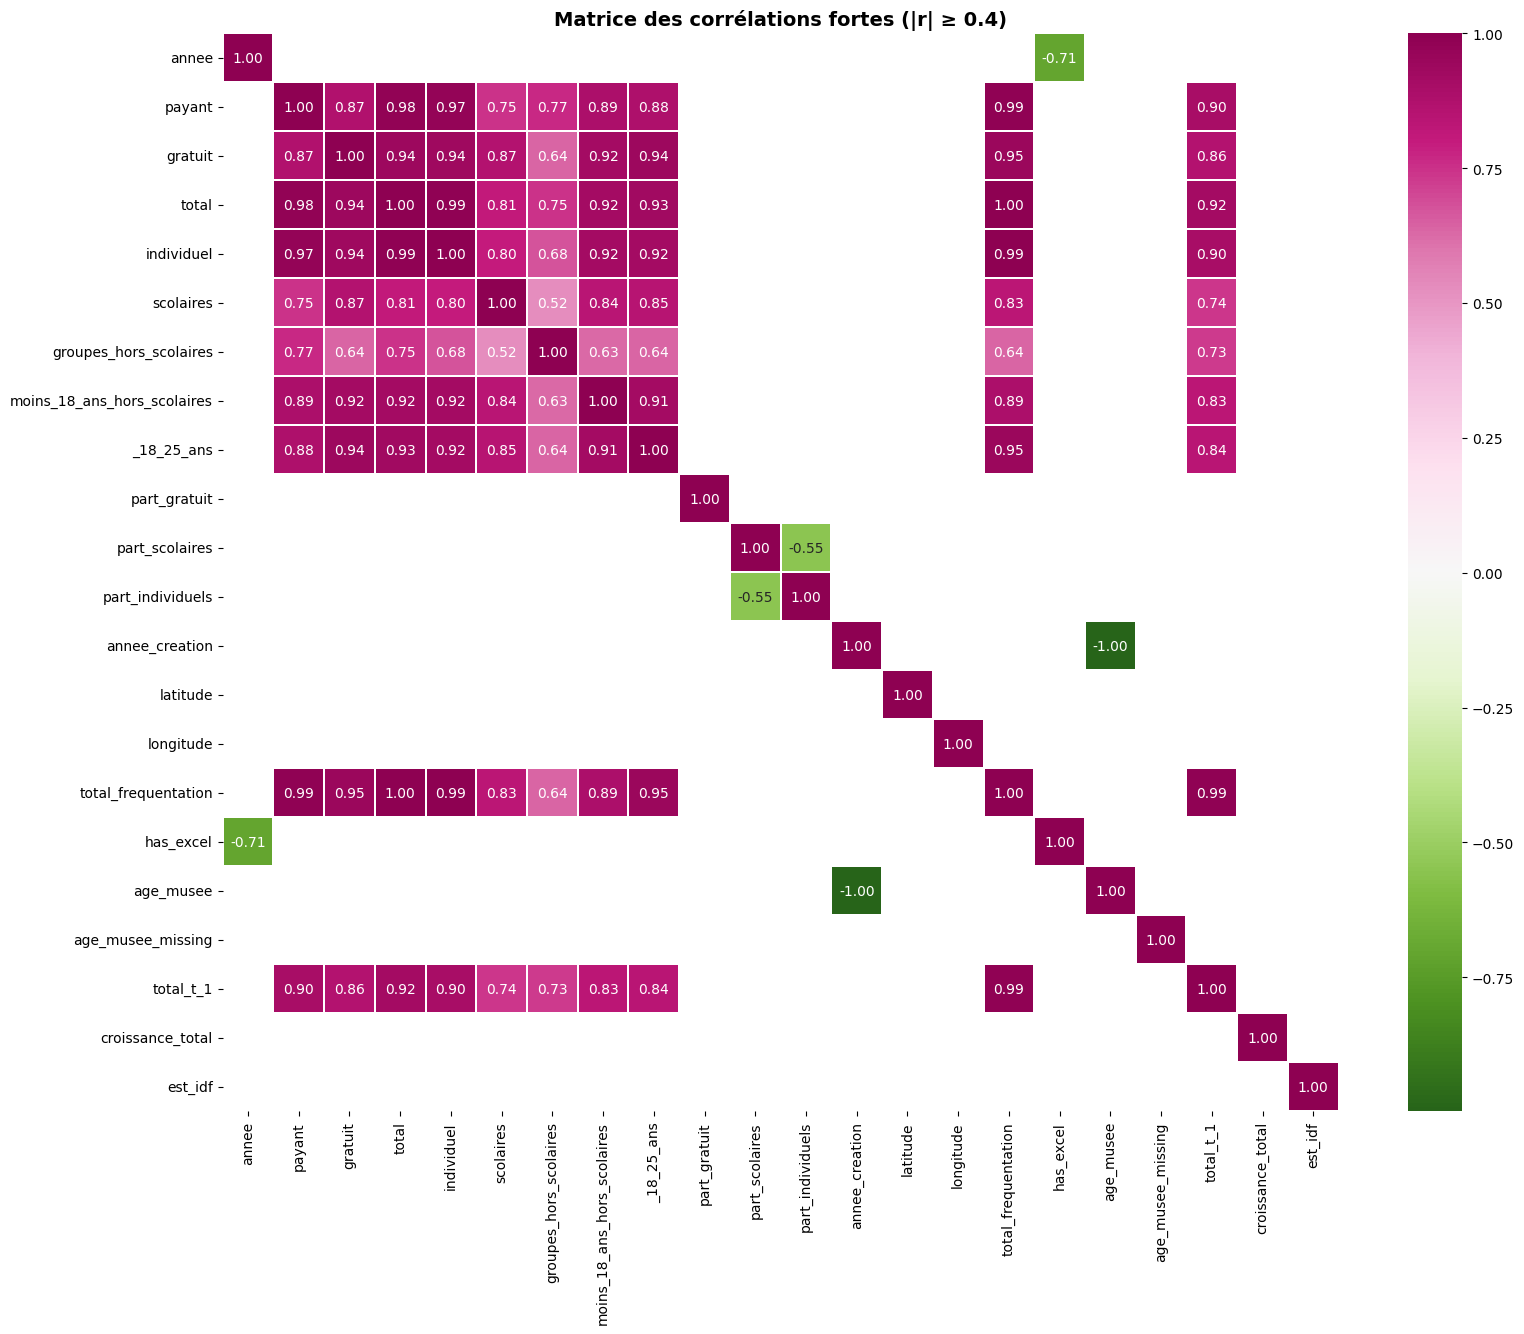

In [16]:
# MATRICE DES CORRÉLATIONS - SANS LES DOMAINES THÉMATIQUES

# Sélectionner uniquement les colonnes numériques
num_cols = df.select_dtypes(include='number')

# Supprimer les colonnes de domaine
num_cols = num_cols.loc[:, ~num_cols.columns.str.startswith("is_")]

# Sélectionner que les corrélation fortes (au moins 0.4 ou au plus -0.4)
corr = num_cols.corr()
strong_corr = corr.where(corr.abs() >= 0.4)

plt.figure(figsize=(18, 14))
sns.heatmap(
    strong_corr,
    cmap="PiYG_r",
    annot=True,       # affiche les valeurs de chaque case    
    center=0,  
    linewidths=0.3,
    fmt=".2f"         # précision au centième près dans chaque case
)

plt.title("Matrice des corrélations fortes (|r| ≥ 0.4)", fontsize=14, fontweight='bold')
plt.show()

Le bloc principal, en haut à gauche de la matrice, montre des corrélations très fortes entre les variables de fréquentation. Cela confirme un phénomène de taille : les musées les plus fréquentés attirent toutes les catégories de visiteurs. Néanmoins, cela implique une multicolinéarité élevée, qu'il faudra faire prendre en compte dans notre modèle prédictif.

La faible corrélation avec la latitude et la longitude semble indiquer que la localisation géographique n'explique pas le volume de visiteurs.

La corrélation très forte entre total_t_1 et total_frequentation (r ≈ 0.92) indique que la fréquentation d’une année est fortement liée à celle de l’année précédente, ce qui nous conforte dans la possibilité et la pertinence d'un modèle prédisant l'évolution de la fréquentation.

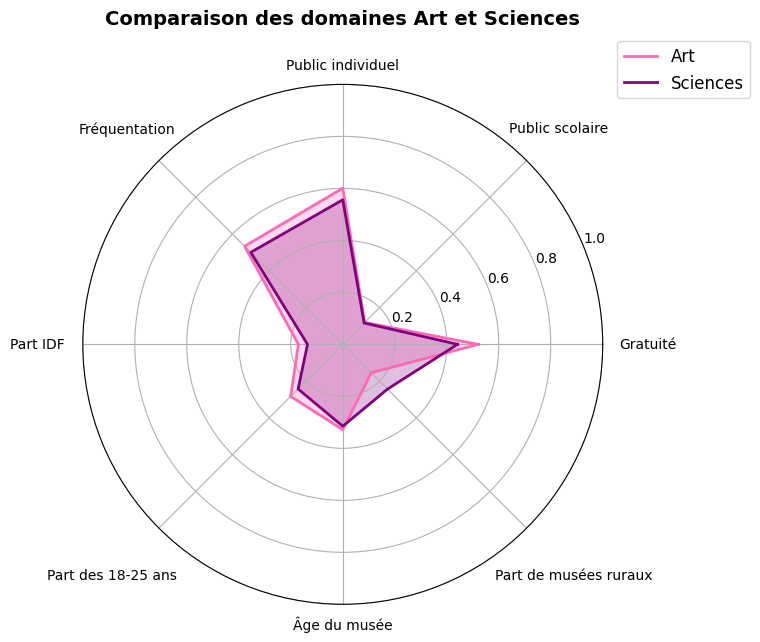

In [42]:
# COMPARAISON DE 2 RADAR CHARTS

# Sélection des colonnes scientifiques
science_cols = [
    "is_technique_et_industrie", 
    "is_sciences_de_la_nature", 
    "is_sciences_fondamentales"
    ]
df_science = df[df[science_cols].sum(axis=1) > 0]

# Sélection des colonnes artistiques
art_cols = [
    "is_beaux_arts", 
    "is_arts_décoratifs", 
    "is_art_moderne_et_contemporain", 
    "is_photographie", 
    "is_arts_de_l'islam"
    ]
df_art = df[df[art_cols].sum(axis=1) > 0]

# Préparation de la variable rural
df["rural"] = df["categorie"] == "musée en milieu rural"

# Définition des variables et de leur appelation
vars_radar = [
    "part_gratuit",
    "part_scolaires",
    "part_individuels",
    "total",
    "est_idf",
    "_18_25_ans",
    "age_musee",
    "rural"
    ]

labels = [
    "Gratuité",
    "Public scolaire",
    "Public individuel",
    "Fréquentation",
    "Part IDF",
    "Part des 18-25 ans",
    "Âge du musée",
    "Part de musées ruraux"
    ]

# Fonction de normalisation par rapport au DataFrame complet
def radar_values_global(df_subset, df_full, vars_radar):
    """
    Calcule les valeurs normalisées à afficher :
        - Les variables continues sont normalisées par min-max.
        - Les variables dispersées sont transformées par log(1 + x) avant normalisation.
        - La variable 'rural' est transformée en moyenne du booléen.
    La fonction renvoie une liste de valeurs comprises entre 0 et 1.
    """
    values = []
    for v in vars_radar:
        col_data_subset = df_subset[v].dropna()
        if v == "rural":
            val_norm = col_data_subset.mean()
        else:
            col_data_full = df_full[v].dropna()
            if v in ["total","_18_25_ans"]:
                col_data_subset = np.log1p(col_data_subset)
                col_data_full = np.log1p(col_data_full)
            min_val = col_data_full.min()
            max_val = col_data_full.max()
            if max_val - min_val == 0:
                val_norm = 0
            else:
                val_norm = (col_data_subset.mean() - min_val) / (max_val - min_val)
        values.append(val_norm)
    return values

# Calcul des valeurs normalisées
values_art = radar_values_global(df_art, df, vars_radar)
values_science = radar_values_global(df_science, df, vars_radar)

# Fermer le radar
values_art.append(values_art[0])
values_science.append(values_science[0])

# Répartition des angles
angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
angles.append(angles[0])

plt.figure(figsize=(8,8))

ax = plt.subplot(111, polar=True)      # transforme l'axe cartésien en polaire

# Plot de l'Art
ax.plot(angles, values_art, linewidth=2, label="Art", color="hotpink")
ax.fill(angles, values_art, alpha=0.25, color="hotpink")

# Plot des Sciences
ax.plot(angles, values_science, linewidth=2, label="Sciences", color="purple")
ax.fill(angles, values_science, alpha=0.25, color="purple")

ax.set_thetagrids(np.degrees(angles[:-1]), labels, fontsize=10)

# Ajuster les noms des axes pour lisibilité
for i, label in enumerate(ax.get_xticklabels()):
    if labels[i] in ["Fréquentation", "Public scolaire", "Gratuité", "Part IDF"]:
        label.set_y(label.get_position()[1] - 0.1)
    elif labels[i] in ["Part des 18-25 ans", "Part de musées ruraux"]:
        label.set_y(label.get_position()[1] - 0.18)

ax.set_ylim(0, 1)
ax.set_title("Comparaison des domaines Art et Sciences", y=1.1, fontsize=14, fontweight='bold')
ax.legend(loc="upper right", bbox_to_anchor=(1.3,1.1), fontsize=12)

plt.tight_layout()
plt.show()


Les musées artistiques et scientifiques ont des profils assez similaires. La part de public scolaire et l'âge moyen des musées sont relativement les mêmes. De plus, la part des 18-25 ans, de l'Île-de-France, du public individuel ou encore la fréquentation le public scolaire ou encore la fréquentation sont proches, bien qu'un peu plus élevé pour les musées artistiques à chaque fois.

La plus grande différence se trouve dans la part de musées ruraux, avec un score de 0.25 pour les musées scientifiques contre 0.15 pour les musées artistiques. On peut aussi noter une plus forte part de gratuité dans les musées artistiques.